In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Загрузка и изучение данных

In [179]:
data = pd.read_csv('/content/train.csv')
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [180]:
headers = data.columns
target = 'Survived'
headers = headers.drop('Survived')
headers = headers.drop('PassengerId')
num_cols = []
cat_cols = []
for head in headers:
  num_cols.append(head) if data[head].dtype != 'object' else cat_cols.append(head)
print(f'num_cols: {num_cols}, cat_cols: {cat_cols}')

num_cols: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], cat_cols: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


Хоть признаки 'Pclass', 'SibSp', 'Parch' кажутся, на первый взгляд, числовыми, они все же являются категориальными. Перенесем их в разряд категориальных. Числовыми останутся только Age и Fare.

In [181]:
cat_cols.append('Pclass')
num_cols.remove('Pclass')
cat_cols.append('SibSp')
num_cols.remove('SibSp')
cat_cols.append('Parch')
num_cols.remove('Parch')

In [182]:
nans = data.isna().sum()
nans = nans[nans != 0]
print(f'Признаки, имеющие пропуски в данных:\n{nans}')

Признаки, имеющие пропуски в данных:
Age         177
Cabin       687
Embarked      2
dtype: int64


Много пропусков у признаков Age (почти 20 %) и Cabin (76%). 
Признак Cabin не будем интерполировать этот признак и уберем из рассмотрения, потому что, во-первых, пропусков слишком много (76%), во-вторых, по смыслу этот признак может описать класс пассажира Pclass. 
С возрастом попробуем несколько вариантов: 1) заменить средним значением, 2) убрать значения с Nan, 3) убрать возраст из пространства признаков

## Карта корреляции

Построим карту корреляции числовых признаков

<Axes: >

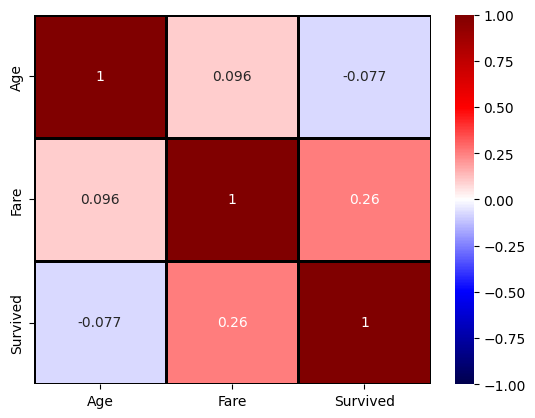

In [183]:
#matrix = np.triu(data.corr())
X_corr = pd.concat([data[num_cols], data[target]], axis=1)
sns.heatmap(X_corr.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='seismic', linewidths=2, linecolor='black', cbar=True) #, mask=matrix)

Из карты корреляции видно, что на выживаемость незначительно влияет платежеспособность, а от возраста выживаемость совсем не зависит.
Платежеспособность связана с классом, поэтому оставим на рассмотрение класс пассажира в категориальных признаках, а платежность из числовых исключим.

Построим гистограммы числовых признаков

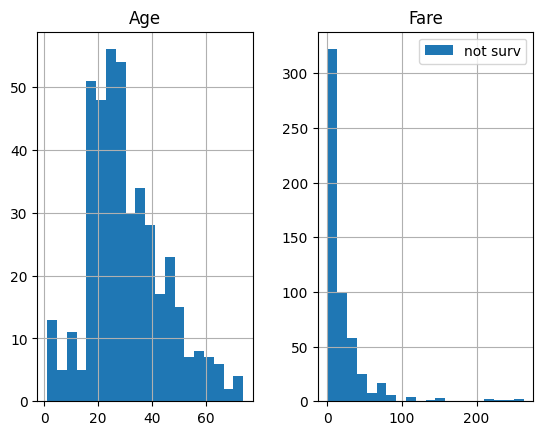

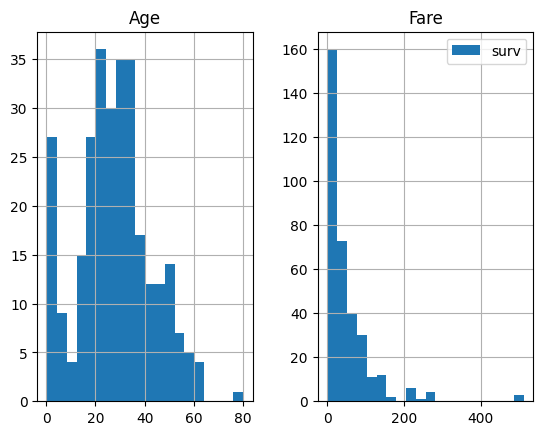

In [184]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

data[num_cols][data[target]==0].hist(bins=20)
patch = mpatches.Patch(label='not surv')
plt.legend(handles=[patch])

data[num_cols][data[target]==1].hist(bins=20)
patch = mpatches.Patch(label='surv')
plt.legend(handles=[patch])

In [132]:
num_cols.remove('Fare')

## Гистограммы катгориальных признаков

Построим гистограммы категориальных признаков. Сразу уберем из признаков Name, Ticket,	Cabin	Embarked

In [185]:
cat_cols.remove('Name')
cat_cols.remove('Ticket')
cat_cols.remove('Cabin')
cat_cols.remove('Embarked')

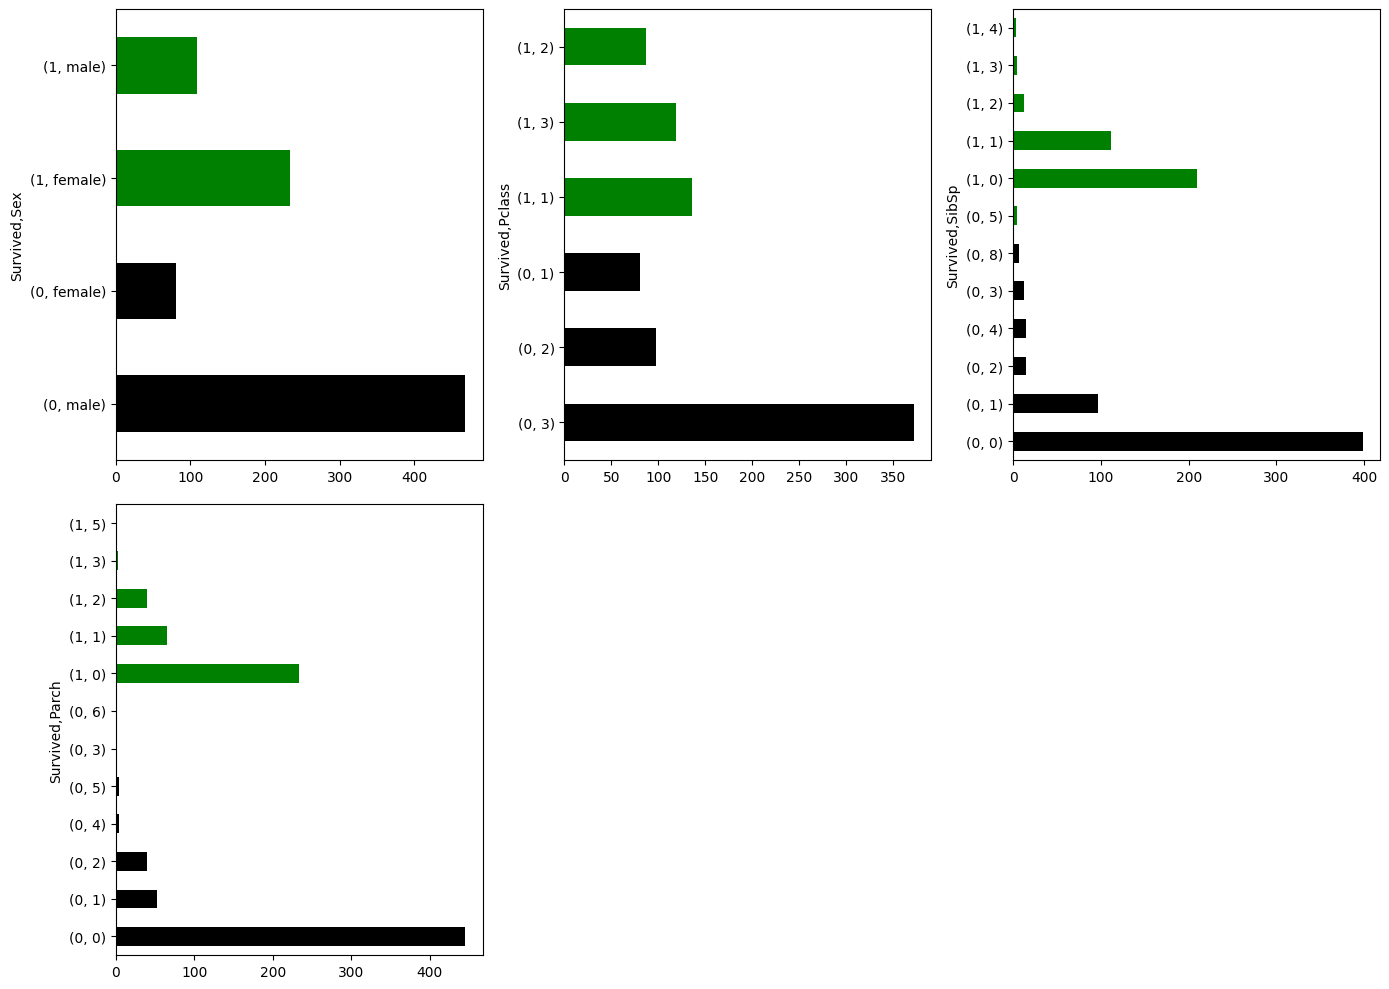

In [186]:
data_surv = data[cat_cols]#[data[target]==1] 
data_surv = pd.concat([data_surv, data[target]], axis=1)

n = 3
n_subplots = int(np.ceil(len(cat_cols)/n))
for i in range(len(cat_cols)):
  plt.subplot(n_subplots, n, i+1, in_layout=True)
  plt.tight_layout()
  ds = data_surv[[cat_cols[i], target]].groupby(target).value_counts()
  n_cat = int(len(ds.index)/2)
  color = n_cat*['black'] + n_cat*['green']
  ds.plot.barh(figsize=(14, 10), ylabel=cat_cols[i], color=color)


По графикам категориальных признаков можем сказать, что погибло:
- значительно больше мужчин, чем женщин
- много представителей 3 класса
- много одиноких людей

In [218]:
X = pd.concat([data[num_cols], data[cat_cols]], axis = 1)
Y = data[target]

# Пайплайны логистической регрессии и случайного леса

Построим пайплайн для логистической регрессии

In [190]:
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [140]:
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary'), cat_cols)],
     verbose_feature_names_out = False)

lrmodel = Pipeline(steps=[
    ('enc', preproc), 
    ('alg', LogisticRegression())
    ])

params = {
    'alg__C': [0.01, 0.1, 1, 5], 
    'alg__penalty':['l2'],  
    'alg__solver':['liblinear'], 
    'alg__class_weight':['balanced']
}

lr =  GridSearchCV(lrmodel, params, cv=5, verbose=0, n_jobs=-1, scoring='roc_auc')

Построим пайплан для случайного леса

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary'), cat_cols)],
     verbose_feature_names_out = False)

forest = make_pipeline(preproc, 
                       RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1))

# Оставить ли Age в качестве признака?

Проверим, влияет ли Age на предскавзание

### Замена пропусков средним

In [219]:
X['Age'].fillna(X['Age'].mean(), inplace=True)
x_tr, x_tst, y_tr, y_tst = train_test_split(X, Y, test_size=0.2, random_state=42)

In [220]:
forest = forest.fit(x_tr, y_tr)

y_predict_age_mean = forest.predict(x_tst)
roc_auc_age_mean = roc_auc_score(y_tst, y_predict_age_mean)
print(roc_auc_age_mean)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.7651866151866152


### Исключение Age из пространства признаков

In [221]:
x_tr.drop(['Age'], axis=1, inplace=True)
x_tst.drop(['Age'], axis=1, inplace=True)

In [222]:
forest = forest.fit(x_tr, y_tr)

y_predict_not_age = forest.predict(x_tst)
roc_auc_not_age = roc_auc_score(y_tst, y_predict_not_age)
print(roc_auc_not_age)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.7651866151866152


### dropna из всех признаков

In [228]:
X = pd.concat([data[num_cols], data[cat_cols], data[target]], axis = 1)
X.dropna(how='any', inplace=True)
Y = X[target]
X.drop('Survived', axis=1, inplace=True)
x_tr, x_tst, y_tr, y_tst = train_test_split(X, Y, test_size=0.2, random_state=42)

In [229]:
forest = forest.fit(x_tr, y_tr)

y_predict_dropna = forest.predict(x_tst)
roc_auc_dropna = roc_auc_score(y_tst, y_predict_dropna)
print(roc_auc_dropna)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.7346059113300493


### Сравнение и заключение по Age

In [230]:
print(f'roc_auc age_mean: {roc_auc_age_mean}\n without age {roc_auc_not_age}\n dropna {roc_auc_dropna}')

roc_auc age_mean: 0.7651866151866152
 without age 0.7651866151866152
 dropna 0.7346059113300493


Видно, что исключение измерений с nan из всей таблицы признаков ухудшает предсказание, что ожидаемо. 
Замена пропусков возраста средним не дает прибавки к точности предсказания в сравнении с предсказанием без учета возраста. Тогда исключим столбец Age и выполним предсказание тестовых данных.

# Обучение моделей и предсказание на тестовых данных

In [231]:
X = pd.concat([data[num_cols], data[cat_cols]], axis = 1)
X.drop(['Age'], axis=1, inplace=True)
Y = data[target]

In [232]:
lr.fit(X, Y)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('enc',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         []),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Sex',
                                                                          'Pclass',
                                                                          'SibSp',
                                                                          'Parch'])],
                                                          verbose_feature_names_out=False)),
                                       ('alg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'alg__C': [0.01, 0.1, 1, 5],
                         'alg__class_weight': ['balanced'],
                         'alg__penalty': ['l2'], 'alg__solver': ['liblinear']},
             scoring='roc_auc')

In [233]:
lr.best_params_

{'alg__C': 1,
 'alg__class_weight': 'balanced',
 'alg__penalty': 'l2',
 'alg__solver': 'liblinear'}

In [234]:
forest = forest.fit(X, Y)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [235]:
data_test = pd.read_csv('/content/test.csv')
data_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [238]:
X_test = pd.concat([data_test[num_cols], data_test[cat_cols]], axis=1)
X_test.drop(['Age'], axis=1, inplace=True)

y_test_pred_lr = lr.predict(X_test)
y_test_pred_lr;

In [242]:
submis = pd.read_csv('/content/gender_submission.csv')
submis['Survived'] = y_test_pred_lr
submis.to_csv('/content/gender_submission_lr.csv', index=False)

In [253]:
y_test_pred_forest = forest.predict(X_test)

submis = pd.read_csv('/content/gender_submission.csv')
submis['Survived'] = y_test_pred_forest
submis.to_csv('/content/gender_submission_forest.csv', index=False)

In [254]:
sum(abs(y_test_pred_forest - y_test_pred_lr))/len(y_test_pred_forest) # Разница между прогнозом логрегресии и леса

0.09330143540669857

Случайный лес дал лучшую оценку 0,769 на kaggle